# CPSC 537 Final Project

## 1. Fetch Players, Teams, Games and Drafts Data Through NBA_API

The basketball dataset is fetched through nba_api, which is an API Client for https://www.nba.com. We saved it as basketball.sqlite under Data directory. Here is the link to this API: https://github.com/swar/nba_api.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
db_path = './RawData/basketball.sqlite'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute('SELECT name from sqlite_master where type= "table"')
table_names = [table[0] for table in cursor.fetchall()]
print(table_names)
#connection.close()

['Player', 'Team', 'Team_Attributes', 'Team_History', 'Player_Attributes', 'Game_Officials', 'Game_Inactive_Players', 'Team_Salary', 'Player_Salary', 'Draft', 'Draft_Combine', 'Player_Photos', 'Player_Bios', 'Game', 'News', 'News_Missing']


Here are 16 tables in this dataset. The names are: Player, Player_Attributes, Player_Salary, Player_Photos, Player_Bios, Team, Team_History, Team_Attributes, Team_Salary, Game, Game_Officials, Game_Inactive_Players, Draft, Draft_Combine, News, News_Missing.

## 2. Download NBA Attendance, Performance Dataset From Data.World


We download NBA team annual attendance data and historical NBA performance data from https://data.world/datasets/nba. Each dataset is a separate table, which contains the statistics of team's participation and performance in each year. The original data is in .xlsx format under Data directory.

In [3]:
performance = pd.read_excel(
    './RawData/Historical NBA Performance.xlsx', 
    header=0)
attendance = pd.read_excel(
    './RawData/NBA Team Annual Attendance.xlsx', 
    header=0)

In [4]:
performance.head()

,Year,Team,Record,Winning Percentage
0,2016-17,Celtics,25-15,0.625
1,2015-16,Celtics,48-34,0.585
2,2014-15,Celtics,40-42,0.488
3,2013-14,Celtics,25-57,0.305
4,2012-13,Celtics,41-40,0.506


In [5]:
attendance.head()

,Starting Year,Rank,Team,Home: Total Games,Home: Total Attendance,Home: Avg Attendance,Home: % Capactiy,Away: Total Games,Away: Total Attendance,Away: Avg Attendance,Away: % Capactiy
0,2015.0,1.0,Bulls,41.0,894659.0,21820.0,104.3,41.0,18156.0,94.5,82.0
1,2015.0,2.0,Cavaliers,41.0,843042.0,20562.0,100.0,41.0,18910.0,98.2,82.0
2,2015.0,3.0,Mavericks,41.0,825901.0,20143.0,104.9,41.0,17727.0,93.4,82.0
3,2015.0,4.0,Raptors,41.0,812863.0,19825.0,100.1,41.0,17162.0,89.2,82.0
4,2015.0,5.0,NY Knicks,41.0,812292.0,19812.0,100.0,41.0,18440.0,96.0,82.0


## 3. Clean the Data and Build a New Database

Here we will connect all of these dataset together and build a new database. In the first step, we run a few scripts to check errors.

In [6]:
performance.isnull().values.any()

False

In [7]:
attendance.isnull().values.any()

False

We find there is no NA value in the performance and attendance dataframe, so we don not need to drop NA values. 

In [72]:
print(min(performance["Winning Percentage"]), max(performance["Winning Percentage"]))

0.106 0.89


The minimum winning percentage is 0.106, and the maximum winning percentage is 0.89. All of the percentage is between 0.106 and 0.89. Therefore, the winning percentage data is clean and we do not need to perform any operations.

In [75]:
print(min(attendance["Home: Total Games"]), max(attendance["Home: Total Games"]))

33.0 41.0


In [76]:
print(min(attendance["Away: Total Games"]), max(attendance["Away: Total Games"]))

33.0 41.0


The total games data in attendance dataframe is reasonable. However, we also notice that the team name in  performance and attendance dataframe is the nick name, but we want a full name and a team id so that it is easiy for query. We use the following code to update the performance dataframe.

In [8]:
query = 'SELECT id, full_name, nickname from Team'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_name = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_name

,id,full_name,nickname
0,1610612737,Atlanta Hawks,Hawks
1,1610612738,Boston Celtics,Celtics
2,1610612739,Cleveland Cavaliers,Cavaliers
3,1610612740,New Orleans Pelicans,Pelicans
4,1610612741,Chicago Bulls,Bulls
5,1610612742,Dallas Mavericks,Mavericks
6,1610612743,Denver Nuggets,Nuggets
7,1610612744,Golden State Warriors,Warriors
8,1610612745,Houston Rockets,Rockets
9,1610612746,Los Angeles Clippers,Clippers


In [9]:
id_list = []
fullname_list = []
nicknameDict = {}

for i in range(len(team_name)):
    nickname = team_name["nickname"][i]
    fullname = team_name["full_name"][i]
    _id = team_name["id"][i]
    nicknameDict[nickname] = [_id, fullname]

for i in range(len(performance)):
    nickname = performance["Team"][i]
    if nickname in nicknameDict:
        id_list.append(nicknameDict[nickname][0])
        fullname_list.append(nicknameDict[nickname][1])
    else:
        id_list.append(None)
        fullname_list.append(None)
        
performance_new = performance.assign(Id=id_list, FullName=fullname_list)        

In [10]:
performance_new.head()

,Year,Team,Record,Winning Percentage,Id,FullName
0,2016-17,Celtics,25-15,0.625,1610612738,Boston Celtics
1,2015-16,Celtics,48-34,0.585,1610612738,Boston Celtics
2,2014-15,Celtics,40-42,0.488,1610612738,Boston Celtics
3,2013-14,Celtics,25-57,0.305,1610612738,Boston Celtics
4,2012-13,Celtics,41-40,0.506,1610612738,Boston Celtics


Similarly, we add id and team full name for attendance dataframe.

In [11]:
id_list = []
fullname_list = []
nicknameDict["NY Knicks"] = ["1610612752", "New York Knicks"]

for i in range(len(attendance)):
    nickname = attendance["Team"][i]
    if nickname in nicknameDict:
        id_list.append(nicknameDict[nickname][0])
        fullname_list.append(nicknameDict[nickname][1])
    else:
        id_list.append(None)
        fullname_list.append(None)

attendance_new = attendance.assign(Id=id_list, FullName=fullname_list)
attendance_new.head()

,Starting Year,Rank,Team,Home: Total Games,Home: Total Attendance,Home: Avg Attendance,Home: % Capactiy,Away: Total Games,Away: Total Attendance,Away: Avg Attendance,Away: % Capactiy,Id,FullName
0,2015.0,1.0,Bulls,41.0,894659.0,21820.0,104.3,41.0,18156.0,94.5,82.0,1610612741,Chicago Bulls
1,2015.0,2.0,Cavaliers,41.0,843042.0,20562.0,100.0,41.0,18910.0,98.2,82.0,1610612739,Cleveland Cavaliers
2,2015.0,3.0,Mavericks,41.0,825901.0,20143.0,104.9,41.0,17727.0,93.4,82.0,1610612742,Dallas Mavericks
3,2015.0,4.0,Raptors,41.0,812863.0,19825.0,100.1,41.0,17162.0,89.2,82.0,1610612761,Toronto Raptors
4,2015.0,5.0,NY Knicks,41.0,812292.0,19812.0,100.0,41.0,18440.0,96.0,82.0,1610612752,New York Knicks


Then we use the following code to build a new database named nba_data.sqlite.

In [12]:
db_path = './RawData/basketball.sqlite'
new_db_path = './DataBase/nba_data.sqlite'
src = sqlite3.connect(db_path)
dst = sqlite3.connect(new_db_path)

with dst:
    src.backup(dst)
    
src.close()

In [13]:
performance_new.to_sql('Performance', dst, if_exists='append', index=False)

/Users/chenjiawen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [14]:
attendance_new.to_sql('Attendance', dst, if_exists='append', index=False)

In [15]:
cursor = dst.cursor()
cursor.execute('SELECT name from sqlite_master where type= "table"')
table_names = [table[0] for table in cursor.fetchall()]
print(table_names)

['Player', 'Team', 'Team_Attributes', 'Team_History', 'Player_Attributes', 'Game_Officials', 'Game_Inactive_Players', 'Team_Salary', 'Player_Salary', 'Draft', 'Draft_Combine', 'Player_Photos', 'Player_Bios', 'Game', 'News', 'News_Missing', 'Performance', 'Attendance']


In [16]:
cursor.execute('SELECT * from Attendance')
len(cursor.fetchall())

476

In [17]:
cursor.execute('SELECT * from Performance')
len(cursor.fetchall())

1417

In [18]:
#dst.close()

From the output above, we successfully connect two dataset together. The new database named nba_data is under DataBase directory.

## 4. Player Data Analysis

Players' data is stored in 5 tables: Player, Player_Attributes, Player_Salary, Player_Photos and Player_Bios. The relationship of these tables is as follows.

![figure1](./Image/player_diagram.png)

### 4.1 Player Table

In [19]:
query = 'SELECT * from Player'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
player = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player.head()

,id,full_name,first_name,last_name,is_active
0,76001,Alaa Abdelnaby,Alaa,Abdelnaby,0
1,76002,Zaid Abdul-Aziz,Zaid,Abdul-Aziz,0
2,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,0
3,51,Mahmoud Abdul-Rauf,Mahmoud,Abdul-Rauf,0
4,1505,Tariq Abdul-Wahad,Tariq,Abdul-Wahad,0


In [20]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4501 entries, 0 to 4500
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4501 non-null   object
 1   full_name   4501 non-null   object
 2   first_name  4501 non-null   object
 3   last_name   4501 non-null   object
 4   is_active   4501 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 175.9+ KB


Player Table has 4500 rows and 5 columns. This table contains players' id, full name, first name, last name and the information on whether the player is active. We use the key word "GROUP BY" to group all of players by the is_active variable to see how many active and inactive players there are.

In [21]:
query = \
    '''
    SELECT is_active, count(*) as count FROM Player 
    GROUP BY is_active;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
active_info = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
active_info

,is_active,count
0,0,3982
1,1,519


From the output above, we can find there are 3982 inactive players and 519 active players.

### 4.2 Player_Attributes Table

In [22]:
query = 'SELECT * from Player_Attributes'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
player_attributes = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_attributes.head()

,ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,...,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,PTS,AST,REB,ALL_STAR_APPEARANCES,PIE
0,76001,Alaa,Abdelnaby,Alaa Abdelnaby,"Abdelnaby, Alaa",A. Abdelnaby,alaa-abdelnaby,1968-06-24T00:00:00,Duke,USA,...,Y,Y,1990,1,25,5.7,0.3,3.3,0.0,NaN
1,76002,Zaid,Abdul-Aziz,Zaid Abdul-Aziz,"Abdul-Aziz, Zaid",Z. Abdul-Aziz,zaid-abdul-aziz,1946-04-07T00:00:00,Iowa State,USA,...,Y,Y,1968,1,5,9.0,1.2,8.0,0.0,NaN
2,76003,Kareem,Abdul-Jabbar,Kareem Abdul-Jabbar,"Abdul-Jabbar, Kareem",K. Abdul-Jabbar,kareem-abdul-jabbar,1947-04-16T00:00:00,UCLA,USA,...,Y,Y,1969,1,1,24.6,3.6,11.2,18.0,NaN
3,51,Mahmoud,Abdul-Rauf,Mahmoud Abdul-Rauf,"Abdul-Rauf, Mahmoud",M. Abdul-Rauf,mahmoud-abdul-rauf,1969-03-09T00:00:00,Louisiana State,USA,...,Y,Y,1990,1,3,14.6,3.5,1.9,0.0,NaN
4,1505,Tariq,Abdul-Wahad,Tariq Abdul-Wahad,"Abdul-Wahad, Tariq",T. Abdul-Wahad,tariq-abdul-wahad,1974-11-03T00:00:00,San Jose State,France,...,Y,Y,1997,1,11,7.8,1.1,3.3,0.0,NaN


In [23]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                4500 non-null   object 
 1   FIRST_NAME                        4500 non-null   object 
 2   LAST_NAME                         4500 non-null   object 
 3   DISPLAY_FIRST_LAST                4500 non-null   object 
 4   DISPLAY_LAST_COMMA_FIRST          4500 non-null   object 
 5   DISPLAY_FI_LAST                   4500 non-null   object 
 6   PLAYER_SLUG                       4500 non-null   object 
 7   BIRTHDATE                         4500 non-null   object 
 8   SCHOOL                            4497 non-null   object 
 9   COUNTRY                           4500 non-null   object 
 10  LAST_AFFILIATION                  4500 non-null   object 
 11  HEIGHT                            4403 non-null   float64
 12  WEIGHT

The Player Attribute table has 4500 rows and 37 columns. Each row is for a distinct player and the columns include the player's id, name, birthdate, school, team, etc.

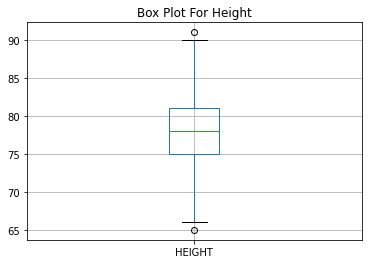

In [24]:
import matplotlib.pyplot as plt

plt.figure()
player_attributes.boxplot(["HEIGHT"])
plt.title("Box Plot For Height")
plt.show()

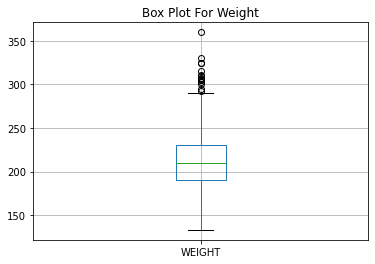

In [25]:
plt.figure()
player_attributes.boxplot(["WEIGHT"])
plt.title("Box Plot For Weight")
plt.show()

The players' average height is around 78 inches and average weight is around 210 pounds.

In [26]:
query = \
    '''
    SELECT Team_id, Team_name, count(*) as Count from Player_Attributes 
    GROUP BY Team_name 
    ORDER BY Count DESC;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_info1 = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_info1.head()

,TEAM_ID,TEAM_NAME,Count
0,0,,664
1,1610612744,Warriors,216
2,1610612752,Knicks,203
3,1610612765,Pistons,202
4,1610612737,Hawks,201


In [27]:
query = \
    '''
    SELECT Team_id, Team_name, count(*) as Count from Player_Attributes 
    GROUP BY Team_name 
    ORDER BY Count ASC;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_info2 = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_info2.head()

,TEAM_ID,TEAM_NAME,Count
0,1610612764,Zephyrs,6
1,1610612737,Blackhawks,10
2,1610610026,Rebels,10
3,1610612764,Packers,11
4,1610610028,Falcons,12


There are 664 players who don't belong to any team, or the team information is missing. Apart from this, we order the table by the number of each team's members. We find the team named Warriors has the maximum number of members while Zephyrs has the minimum number.

### 4.3 Player_Salary Table

In [28]:
query = 'SELECT * from Player_Salary'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
player_salary = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_salary.head()

,slugSeason,nameTeam,namePlayer,statusPlayer,isFinalSeason,isWaived,isOnRoster,isNonGuaranteed,isTeamOption,isPlayerOption,typeContractDetail,value
0,2020-21,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
1,2021-22,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
2,2022-23,Atlanta Hawks,Bogdan Bogdanovic,current roster,0,0,1,0,0,0,Guaranteed,18000000.0
3,2023-24,Atlanta Hawks,Bogdan Bogdanovic,current roster,1,0,1,0,0,1,Player Option,18000000.0
4,2020-21,Atlanta Hawks,Brandon Goodwin,current roster,0,0,1,0,0,0,Guaranteed,1701593.0


In [29]:
player_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   slugSeason          1292 non-null   object 
 1   nameTeam            1292 non-null   object 
 2   namePlayer          1292 non-null   object 
 3   statusPlayer        1292 non-null   object 
 4   isFinalSeason       1292 non-null   int64  
 5   isWaived            1292 non-null   int64  
 6   isOnRoster          1292 non-null   int64  
 7   isNonGuaranteed     1292 non-null   int64  
 8   isTeamOption        1292 non-null   int64  
 9   isPlayerOption      1292 non-null   int64  
 10  typeContractDetail  1292 non-null   object 
 11  value               1292 non-null   float64
dtypes: float64(1), int64(6), object(5)
memory usage: 121.2+ KB


This table has 1292 rows and 12 columns. Then we draw a histogram to find the distribution of player's salary.

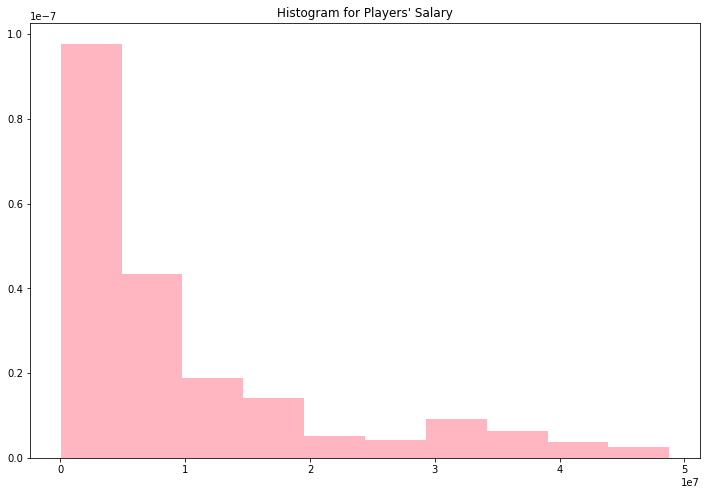

In [30]:
player_salary.dropna(axis=0)
plt.figure(figsize=(12,8))
plt.hist(x=player_salary['value'], color="lightpink", density=True)
plt.title("Histogram for Players' Salary")
plt.show()

In [31]:
print(max(player_salary['value']), min(player_salary['value']))

48787676.0 25000.0


The distribution of players' salary is highly right skewed. Only a very small number of players can get high salaries. The maximum salary is 48787676 dollars and the minimum salary is 25000 dollars.

### 4.4 Player_Photos Table

In [32]:
query = 'SELECT * from Player_Photos'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
player_photos = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_photos.head()

,isActive,isRookie,namePlayer,idPlayer,countSeasons,yearSeasonFirst,yearSeasonLast,idTeam,hasGamesPlayedFlag,urlPlayerStats,urlPlayerThumbnail,urlPlayerHeadshot,urlPlayerActionPhoto,hasHeadShot,hasThumbnail,hasAction,urlPlayerPhoto
0,0,0,Alaa Abdelnaby,76001.0,4.0,1990.0,1994.0,NaN,0,https://stats.nba.com/player/76001,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76001.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
1,0,0,Zaid Abdul-Aziz,76002.0,9.0,1968.0,1977.0,NaN,0,https://stats.nba.com/player/76002,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76002.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/76...
2,0,0,Kareem Abdul-Jabbar,76003.0,19.0,1969.0,1988.0,NaN,0,https://stats.nba.com/player/76003,https://stats.nba.com/media/players/230x185/76...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/76003.png,1.0,1.0,1.0,https://ak-static.cms.nba.com/wp-content/uploa...
3,0,0,Mahmoud Abdul-Rauf,51.0,10.0,1990.0,2000.0,NaN,0,https://stats.nba.com/player/51,https://stats.nba.com/media/players/230x185/51...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/51.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/51...
4,0,0,Tariq Abdul-Wahad,1505.0,6.0,1997.0,2003.0,NaN,0,https://stats.nba.com/player/1505,https://stats.nba.com/media/players/230x185/15...,https://ak-static.cms.nba.com/wp-content/uploa...,https://stats.nba.com/media/players/700/1505.png,0.0,1.0,1.0,https://stats.nba.com/media/players/230x185/15...


In [33]:
player_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4593 entries, 0 to 4592
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isActive              4593 non-null   int64  
 1   isRookie              4593 non-null   int64  
 2   namePlayer            4593 non-null   object 
 3   idPlayer              4593 non-null   float64
 4   countSeasons          4593 non-null   float64
 5   yearSeasonFirst       4593 non-null   float64
 6   yearSeasonLast        4593 non-null   float64
 7   idTeam                491 non-null    float64
 8   hasGamesPlayedFlag    4593 non-null   int64  
 9   urlPlayerStats        4593 non-null   object 
 10  urlPlayerThumbnail    4593 non-null   object 
 11  urlPlayerHeadshot     4593 non-null   object 
 12  urlPlayerActionPhoto  4593 non-null   object 
 13  hasHeadShot           4378 non-null   float64
 14  hasThumbnail          4378 non-null   float64
 15  hasAction            

This table has 4593 rows and 17 columns. Each row contains one player and the public link to his photo.

### 4.5 Player_Bios Table

In [34]:
query = 'SELECT * from Player_Bios'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
player_bios = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
player_bios.head()

,namePlayerBREF,urlPlayerBioBREF,nameTable,urlPlayerImageBREF,slugPlayerBREF,numberTransactionPlayer,dateTransaction,descriptionTransaction,isGLeagueMovement,isDraft,...,yearsExperience,nameTwitter,yearHighSchool,rankHighSchool,dateDeath,high schools,descriptionRelatives,descriptionHOF,playerNicknames,colleges
0,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,1.0,5647.0,Drafted by the Los Angeles Lakers in the 1st r...,0.0,1.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
1,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,2.0,8602.0,Released by the Los Angeles Lakers.,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
2,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,3.0,8671.0,Signed as an unrestricted free agent with the ...,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
3,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,4.0,9856.0,"Traded by the Phoenix Suns with Sam Cassell, M...",0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None
4,A.C. Green,https://www.basketball-reference.com/players/g...,Transactions,https://www.basketball-reference.com/req/20210...,greenac01,5.0,10835.0,Traded by the Dallas Mavericks to the Los Ange...,0.0,0.0,...,NaN,None,NaN,NaN,NaN,None,None,None,None,None


In [35]:
player_bios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42749 entries, 0 to 42748
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   namePlayerBREF           42749 non-null  object 
 1   urlPlayerBioBREF         42749 non-null  object 
 2   nameTable                42749 non-null  object 
 3   urlPlayerImageBREF       28285 non-null  object 
 4   slugPlayerBREF           42749 non-null  object 
 5   numberTransactionPlayer  26970 non-null  float64
 6   dateTransaction          26962 non-null  float64
 7   descriptionTransaction   26970 non-null  object 
 8   isGLeagueMovement        26970 non-null  float64
 9   isDraft                  26970 non-null  float64
 10  isSigned                 26970 non-null  float64
 11  isWaived                 26970 non-null  float64
 12  isTraded                 26970 non-null  float64
 13  slugSeason               15602 non-null  object 
 14  nameTeam              

The Player_Bios table is similar to Player_Attributes table, but has more detailed information. For example, Player_Attributes table only show the college name for each player, but the Player_Bios table has the college name, high school name, high school year, etc. The Player_Bios table has 42749 rows and 40 columns.

In [36]:
query = \
    '''
    SELECT numberTransactionPlayer, count(*) as count from Player_Bios 
    GROUP BY numberTransactionPlayer 
    ORDER BY Count DESC;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
transaction_info = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
transaction_info.head()

,numberTransactionPlayer,count
0,NaN,15779
1,1.0,4010
2,2.0,3541
3,3.0,3028
4,4.0,2612


The majority of players does not have a transaction. 67.8% of players have less than 5 transactions.

## 5. Team Data Analysis

Teams' data is stored in 4 tables: Team, Team_History, Team_Attributes, Team_Salary.

![figure2](./Image/team_diagram.png)

### 5.1 Team Table

In [37]:
query = 'SELECT * from Team'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [38]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30 non-null     object
 1   full_name     30 non-null     object
 2   abbreviation  30 non-null     object
 3   nickname      30 non-null     object
 4   city          30 non-null     object
 5   state         30 non-null     object
 6   year_founded  30 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 1.8+ KB


There are 30 distinct teams in this table. Each row of this table contains the id, full name, abbreviation, nickname, city, state, founded year for the team.

In [39]:
query = \
    """
    SELECT id, full_name, abbreviation, year_founded, (2022 - year_founded) as age
    FROM Team
    ORDER BY age DESC
    """
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_age = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_age.head()

,id,full_name,abbreviation,year_founded,age
0,1610612738,Boston Celtics,BOS,1946,76
1,1610612744,Golden State Warriors,GSW,1946,76
2,1610612752,New York Knicks,NYK,1946,76
3,1610612747,Los Angeles Lakers,LAL,1948,74
4,1610612758,Sacramento Kings,SAC,1948,74


In [40]:
query = \
    """
    SELECT id, full_name, abbreviation, year_founded, (2022 - year_founded) as age
    FROM Team
    ORDER BY age ASC
    """
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_age = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_age.head()

,id,full_name,abbreviation,year_founded,age
0,1610612740,New Orleans Pelicans,NOP,2002,20
1,1610612761,Toronto Raptors,TOR,1995,27
2,1610612763,Memphis Grizzlies,MEM,1995,27
3,1610612750,Minnesota Timberwolves,MIN,1989,33
4,1610612753,Orlando Magic,ORL,1989,33


Boston Celtics, Golden State Warriors and New York Knicks are the three oldest NBA teams. New Orleans Pelicans is the youngest team, which is founded in 2022.

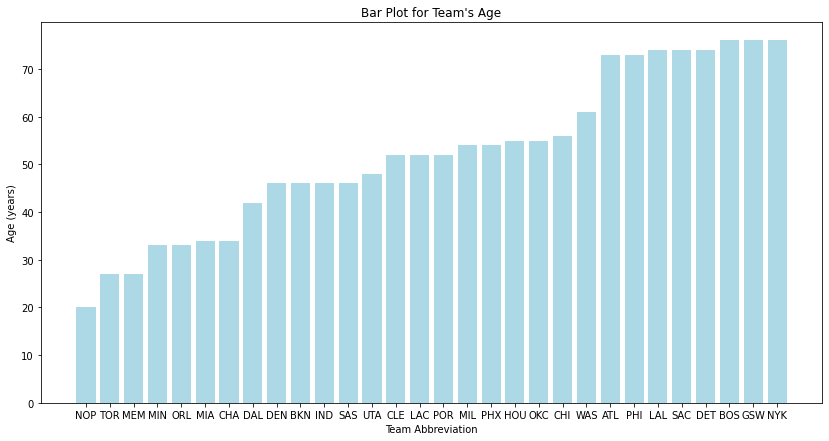

In [41]:
plt.figure(figsize= (14,7))
plt.bar(x=team_age["abbreviation"], height=team_age["age"], color="lightblue")
plt.xlabel("Team Abbreviation")
plt.ylabel("Age (years)")
plt.title("Bar Plot for Team's Age")
plt.show()

### 5.2 Team History Table

In [42]:
query = 'SELECT * from Team_History'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_history = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_history.head()

,ID,CITY,NICKNAME,YEARFOUNDED,YEARACTIVETILL
0,1610612737,Atlanta,Hawks,1968,2019
1,1610612737,St. Louis,Hawks,1955,1967
2,1610612737,Milwaukee,Hawks,1951,1954
3,1610612737,Tri-Cities,Blackhawks,1949,1950
4,1610612738,Boston,Celtics,1946,2019


In [43]:
team_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              60 non-null     object
 1   CITY            60 non-null     object
 2   NICKNAME        60 non-null     object
 3   YEARFOUNDED     60 non-null     object
 4   YEARACTIVETILL  60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


This table has 60 rows and 5 columns, showing each team's id, city, nickname, founded year and the active year.

In [44]:
query = 'SELECT distinct(city) from Team_History'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_city = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              60 non-null     object
 1   CITY            60 non-null     object
 2   NICKNAME        60 non-null     object
 3   YEARFOUNDED     60 non-null     object
 4   YEARACTIVETILL  60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


We use "distinct" key word to check whether there are two teams founded in the same city. The result shows that we have 60 distinct cities, which means each team is founded in a different city.

### 5.3 Team Attributes Table

In [45]:
query = 'SELECT * from Team_Attributes'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_attributes = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_attributes.head()

,ID,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION,FACEBOOK_WEBSITE_LINK,INSTAGRAM_WEBSITE_LINK,TWITTER_WEBSITE_LINK
0,1610612737,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Nate McMillan,Erie Bayhawks,https://www.facebook.com/hawks,https://instagram.com/atlhawks,https://twitter.com/ATLHawks
1,1610612738,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws,https://www.facebook.com/bostonceltics,https://instagram.com/celtics,https://twitter.com/celtics
2,1610612739,CLE,Cavaliers,1970,Cleveland,Rocket Mortgage FieldHouse,20562.0,Dan Gilbert,Koby Altman,JB Bickerstaff,Canton Charge,https://www.facebook.com/Cavs,https://instagram.com/cavs,https://twitter.com/cavs
3,1610612740,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Stan Van Gundy,No Affiliate,https://www.facebook.com/PelicansNBA,https://instagram.com/pelicansnba,https://twitter.com/PelicansNBA
4,1610612741,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Arturas Karnisovas,Billy Donovan,Windy City Bulls,https://www.facebook.com/chicagobulls,https://instagram.com/chicagobulls,https://twitter.com/chicagobulls


In [46]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      30 non-null     object 
 1   ABBREVIATION            30 non-null     object 
 2   NICKNAME                30 non-null     object 
 3   YEARFOUNDED             30 non-null     object 
 4   CITY                    30 non-null     object 
 5   ARENA                   30 non-null     object 
 6   ARENACAPACITY           20 non-null     float64
 7   OWNER                   30 non-null     object 
 8   GENERALMANAGER          30 non-null     object 
 9   HEADCOACH               30 non-null     object 
 10  DLEAGUEAFFILIATION      30 non-null     object 
 11  FACEBOOK_WEBSITE_LINK   30 non-null     object 
 12  INSTAGRAM_WEBSITE_LINK  30 non-null     object 
 13  TWITTER_WEBSITE_LINK    30 non-null     object 
dtypes: float64(1), object(13)
memory usage: 3.4+

This table has 30 rows and 14 columns. The column contains information including the name, city, arena, owner, and some public website links.

In [47]:
query = \
    '''
    SELECT ARENACAPACITY from Team_Attributes 
    WHERE "ARENACAPACITY" != 0;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
capacity = [i[0] for i in cursor.fetchall()]
print("Minimum arena capacity:", min(capacity), "\nMaximum arena capacity:", max(capacity))

Minimum arena capacity: 17500.0 
Maximum arena capacity: 21711.0


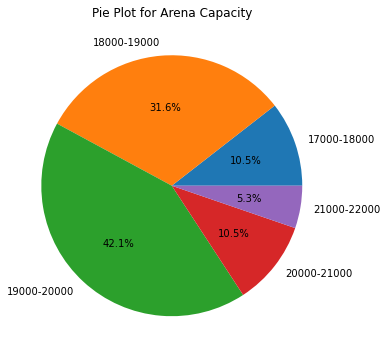

In [48]:
capacity_labels = ["17000-18000", "18000-19000", "19000-20000", "20000-21000", "21000-22000"]
capacity_counts = [0]*5
for cp in capacity:
    if cp < 18000:
        capacity_counts[0] += 1
    elif cp < 19000:
        capacity_counts[1] += 1
    elif cp < 20000:
        capacity_counts[2] += 1
    elif cp < 21000:
        capacity_counts[3] += 1
    else:
        capacity_counts[4] += 1
plt.figure(figsize=(6,6))
plt.pie(x=capacity_counts, labels=capacity_labels, autopct='%1.1f%%')
plt.title("Pie Plot for Arena Capacity")
plt.show()

We draw a pie plot for arena's capacity. The maximum capacity is 21711 while the minimum is 17500. Around 42.1% of arenas have a capacity between 19000 and 20000.

### 5.4 Team Salary Table

In [49]:
query = 'SELECT * from Team_Salary'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
team_salary = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
team_salary.head()

,nameTeam,slugTeam,urlTeamSalaryHoopsHype,X2020-21,X2021-22,X2022-23,X2023-24,X2024-25,X2025-26
0,Atlanta Hawks,ATL,http://hoopshype.com/salaries/atlanta_hawks/,118647039.0,95496087.0,59656896.0,18000000.0,0.0,0.0
1,Boston Celtics,BOS,http://hoopshype.com/salaries/boston_celtics/,132032864.0,132077647.0,95626895.0,62027548.0,34844000.0,37092000.0
2,Brooklyn Nets,BKN,http://hoopshype.com/salaries/brooklyn_nets/,168854452.0,165982367.0,157168219.0,19928571.0,0.0,0.0
3,Charlotte Hornets,CHA,http://hoopshype.com/salaries/charlotte_hornets/,108218809.0,83125939.0,44614401.0,31500000.0,0.0,0.0
4,Chicago Bulls,CHI,http://hoopshype.com/salaries/chicago_bulls/,128963580.0,96304124.0,22000000.0,0.0,0.0,0.0


In [50]:
team_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   nameTeam                30 non-null     object 
 1   slugTeam                30 non-null     object 
 2   urlTeamSalaryHoopsHype  30 non-null     object 
 3   X2020-21                30 non-null     float64
 4   X2021-22                30 non-null     float64
 5   X2022-23                30 non-null     float64
 6   X2023-24                30 non-null     float64
 7   X2024-25                30 non-null     float64
 8   X2025-26                30 non-null     float64
dtypes: float64(6), object(3)
memory usage: 2.2+ KB


This table has 30 rows and 9 columns. The columns show annual salary from 2020 to 2025 (expected). 

## 6. Game Data Analysis

There are two game related tables: Game and Game_Officials.

![figure3](./Image/game_diagram.png)

### 6.1 Game Table

In [51]:
query = 'SELECT * from Game'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
game = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
game.head()

,GAME_ID,SEASON_ID,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,GAME_DATE,MATCHUP_HOME,WL_HOME,MIN_HOME,FGM_HOME,...,LAST_GAME_VISITOR_TEAM_CITY1,LAST_GAME_VISITOR_TEAM_POINTS,HOME_TEAM_WINS,HOME_TEAM_LOSSES,SERIES_LEADER,VIDEO_AVAILABLE_FLAG,PT_AVAILABLE,PT_XYZ_AVAILABLE,HUSTLE_STATUS,HISTORICAL_STATUS
0,0024600001,21946,1610610035,HUS,Toronto Huskies,1946-11-01,HUS vs. NYK,L,0,25.0,...,None,None,3.0,3.0,Tied,0.0,0.0,0.0,0.0,1.0
1,0024600003,21946,1610610034,BOM,St. Louis Bombers,1946-11-02,BOM vs. PIT,W,0,20.0,...,None,None,5.0,1.0,St. Louis,0.0,0.0,0.0,0.0,1.0
2,0024600004,21946,1610610025,CHS,Chicago Stags,1946-11-02,CHS vs. NYK,W,0,21.0,...,None,None,3.0,3.0,Tied,0.0,0.0,0.0,0.0,1.0
3,0024600002,21946,1610610032,PRO,Providence Steamrollers,1946-11-02,PRO vs. BOS,W,0,21.0,...,None,None,5.0,1.0,Providence,0.0,0.0,0.0,0.0,1.0
4,0024600005,21946,1610610028,DEF,Detroit Falcons,1946-11-02,DEF vs. WAS,L,0,10.0,...,None,None,1.0,5.0,Washington,0.0,0.0,0.0,0.0,1.0


In [52]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62448 entries, 0 to 62447
Columns: 149 entries, GAME_ID to HISTORICAL_STATUS
dtypes: float64(24), int64(8), object(117)
memory usage: 71.0+ MB


This table has 62448 different rows and 149 columns.

In [53]:
list(game.columns)

['GAME_ID',
 'SEASON_ID',
 'TEAM_ID_HOME',
 'TEAM_ABBREVIATION_HOME',
 'TEAM_NAME_HOME',
 'GAME_DATE',
 'MATCHUP_HOME',
 'WL_HOME',
 'MIN_HOME',
 'FGM_HOME',
 'FGA_HOME',
 'FG_PCT_HOME',
 'FG3M_HOME',
 'FG3A_HOME',
 'FG3_PCT_HOME',
 'FTM_HOME',
 'FTA_HOME',
 'FT_PCT_HOME',
 'OREB_HOME',
 'DREB_HOME',
 'REB_HOME',
 'AST_HOME',
 'STL_HOME',
 'BLK_HOME',
 'TOV_HOME',
 'PF_HOME',
 'PTS_HOME',
 'PLUS_MINUS_HOME',
 'VIDEO_AVAILABLE_HOME',
 'TEAM_ID_AWAY',
 'TEAM_ABBREVIATION_AWAY',
 'TEAM_NAME_AWAY',
 'MATCHUP_AWAY',
 'WL_AWAY',
 'MIN_AWAY',
 'FGM_AWAY',
 'FGA_AWAY',
 'FG_PCT_AWAY',
 'FG3M_AWAY',
 'FG3A_AWAY',
 'FG3_PCT_AWAY',
 'FTM_AWAY',
 'FTA_AWAY',
 'FT_PCT_AWAY',
 'OREB_AWAY',
 'DREB_AWAY',
 'REB_AWAY',
 'AST_AWAY',
 'STL_AWAY',
 'BLK_AWAY',
 'TOV_AWAY',
 'PF_AWAY',
 'PTS_AWAY',
 'PLUS_MINUS_AWAY',
 'VIDEO_AVAILABLE_AWAY',
 'GAME_DATE_EST',
 'GAME_SEQUENCE',
 'GAME_STATUS_ID',
 'GAME_STATUS_TEXT',
 'GAMECODE',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'LIVE_PERIOD',
 'LIVE_PC_TIM

The column names are listed as above.

In [54]:
query = \
    '''
    SELECT 
        Team_id_home, Team_name_home, 
        SUM(HOME_TEAM_WINS)/(SUM(HOME_TEAM_WINS)+SUM(HOME_TEAM_LOSSES)) as HOME_WINNING_RATE
    FROM Game
    GROUP BY Team_id_home
    ORDER BY HOME_WINNING_RATE DESC
    LIMIT 5;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
home_winning_rate = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
home_winning_rate

,TEAM_ID_HOME,TEAM_NAME_HOME,HOME_WINNING_RATE
0,1610610023,Anderson Packers,0.648936
1,1610612738,Boston Celtics,0.620141
2,1610612759,San Antonio Spurs,0.604579
3,1610610025,Chicago Stags,0.602797
4,1610610036,Washington Capitols,0.600000


Historically, Anderson Packers has the highest home winning rate, which is 64.89%. Boston Celtics has the second highest home winning rate, which is 62.01%.

In [55]:
query = \
    '''
    SELECT 
        Team_id_away, Team_name_away, 
        SUM(HOME_TEAM_LOSSES)/(SUM(HOME_TEAM_WINS)+SUM(HOME_TEAM_LOSSES)) as AWAY_WINNING_RATE
    FROM Game
    GROUP BY TEAM_ID_AWAY
    ORDER BY AWAY_WINNING_RATE DESC
    LIMIT 5;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
away_winning_rate = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
away_winning_rate

,TEAM_ID_AWAY,TEAM_NAME_AWAY,AWAY_WINNING_RATE
0,1610612738,Boston Celtics,0.610176
1,1610612759,San Antonio Spurs,0.600958
2,1610610025,Chicago Stags,0.600277
3,1610610023,Anderson Packers,0.595506
4,1610610036,Washington Capitols,0.581579


Historically, Boston CWltics has the highest away winning rate, which is 61.02%. San Antonio Spurs has the second highest home winning rate, which is 60.10%.

We are interested in the changes of historical home winning rate and away winning rate for Boston Celtics. Therefore, we fetch data by sql statement and draw a line chart.

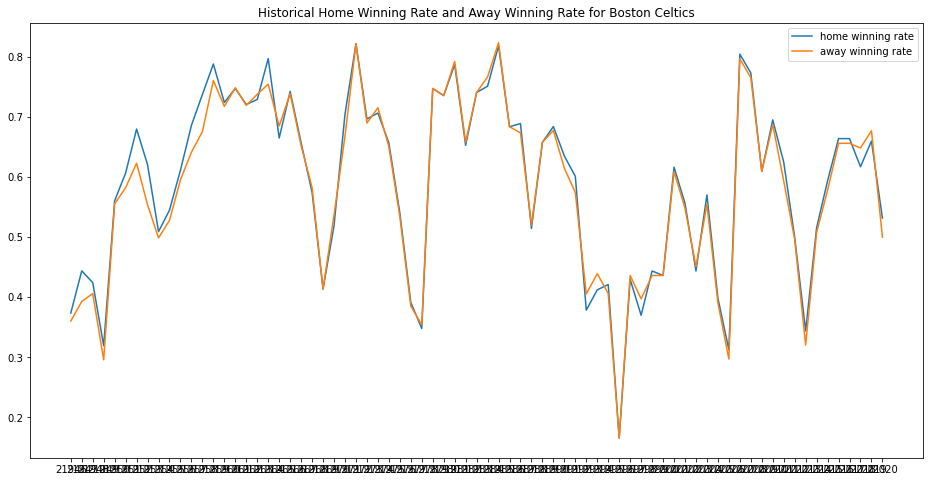

In [56]:
query1 = \
    '''
    SELECT 
        Season_id, 
        SUM(HOME_TEAM_WINS)/(SUM(HOME_TEAM_WINS)+SUM(HOME_TEAM_LOSSES)) as HOME_WINNING_RATE
    FROM Game
    GROUP BY SEASON_ID, TEAM_ID_HOME
    HAVING TEAM_ID_HOME = '1610612738';
    '''
query2 = \
    '''
    SELECT 
        Season_id, 
        SUM(HOME_TEAM_LOSSES)/(SUM(HOME_TEAM_WINS)+SUM(HOME_TEAM_LOSSES)) as AWAY_WINNING_RATE
    FROM Game
    GROUP BY SEASON_ID, TEAM_ID_AWAY
    HAVING TEAM_ID_AWAY = '1610612738';
    '''

cursor.execute(query1)
cols = [column[0] for column in cursor.description]
BOS_home_winning_rate = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
cursor.execute(query2)
cols = [column[0] for column in cursor.description]
BOS_away_winning_rate = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
plt.figure(figsize=(16,8))
plt.plot(BOS_home_winning_rate.iloc[:,0], BOS_home_winning_rate.iloc[:,1], label="home winning rate")
plt.plot(BOS_away_winning_rate.iloc[:,0], BOS_away_winning_rate.iloc[:,1], label="away winning rate")
plt.legend()
plt.title("Historical Home Winning Rate and Away Winning Rate for Boston Celtics")
plt.show()

### 6.2 Game Officials Table

In [57]:
query = 'SELECT * from Game_Officials'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
game_officials = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
game_officials.head()

,OFFICIAL_ID,FIRST_NAME,LAST_NAME,JERSEY_NUM,GAME_ID
0,1165,Luis,Grillo,8,0029600059
1,1140,Bruce,Alexander,9,0029600059
2,1153,Joe,Crawford,17,0029600059
3,1146,Tony,Brothers,56,0029600121
4,1157,Terry,Durham,31,0029600121


In [58]:
game_officials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65158 entries, 0 to 65157
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OFFICIAL_ID  65158 non-null  object
 1   FIRST_NAME   65158 non-null  object
 2   LAST_NAME    65158 non-null  object
 3   JERSEY_NUM   65158 non-null  object
 4   GAME_ID      65158 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


This table has 65168 rows and 5 columns, showing official id, first name, last name, jersey numbers and game id for each game.

### 7. Draft Data Analysis

NBA holds annual draft for teams to hire new players. There are two draft related tables: Draft and Draft_Combine.

### 7.1 Draft Table

In [59]:
query = 'SELECT * from Draft'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
draft = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
draft.head()

,yearDraft,numberPickOverall,numberRound,numberRoundPick,namePlayer,slugTeam,nameOrganizationFrom,typeOrganizationFrom,idPlayer,idTeam,nameTeam,cityTeam,teamName,PLAYER_PROFILE_FLAG,slugOrganizationTypeFrom,locationOrganizationFrom
0,2020.0,1.0,1.0,1.0,Anthony Edwards,MIN,Georgia,College/University,1630162.0,1.610613e+09,Minnesota Timberwolves,Minnesota,Timberwolves,1.0,COL,None
1,2020.0,2.0,1.0,2.0,James Wiseman,GSW,Memphis,College/University,1630164.0,1.610613e+09,Golden State Warriors,Golden State,Warriors,1.0,COL,None
2,2020.0,3.0,1.0,3.0,LaMelo Ball,CHA,Illawarra,Other Team/Club,1630163.0,1.610613e+09,Charlotte Hornets,Charlotte,Hornets,1.0,PRO,Australia
3,2020.0,4.0,1.0,4.0,Patrick Williams,CHI,Florida State,College/University,1630172.0,1.610613e+09,Chicago Bulls,Chicago,Bulls,1.0,COL,None
4,2020.0,5.0,1.0,5.0,Isaac Okoro,CLE,Auburn,College/University,1630171.0,1.610613e+09,Cleveland Cavaliers,Cleveland,Cavaliers,1.0,COL,None


In [60]:
draft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   yearDraft                 7890 non-null   float64
 1   numberPickOverall         7890 non-null   float64
 2   numberRound               7890 non-null   float64
 3   numberRoundPick           7890 non-null   float64
 4   namePlayer                7890 non-null   object 
 5   slugTeam                  7890 non-null   object 
 6   nameOrganizationFrom      7875 non-null   object 
 7   typeOrganizationFrom      7875 non-null   object 
 8   idPlayer                  7890 non-null   float64
 9   idTeam                    7890 non-null   float64
 10  nameTeam                  7890 non-null   object 
 11  cityTeam                  7890 non-null   object 
 12  teamName                  7890 non-null   object 
 13  PLAYER_PROFILE_FLAG       7890 non-null   float64
 14  slugOrga

This table has 7890 rows and 16 columns, showing official id, first name, last name, jersey numbers and game id for each game.

In [61]:
query = \
    '''
    SELECT * from Draft
    WHERE numberPickOverall = (
        SELECT MAX(numberPickOverall) from Draft
        );
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
draft_max_num_pcks = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
draft_max_num_pcks

,yearDraft,numberPickOverall,numberRound,numberRoundPick,namePlayer,slugTeam,nameOrganizationFrom,typeOrganizationFrom,idPlayer,idTeam,nameTeam,cityTeam,teamName,PLAYER_PROFILE_FLAG,slugOrganizationTypeFrom,locationOrganizationFrom
0,1970.0,239.0,19.0,3.0,Mark Gabriel,POR,Hanover,College/University,81241.0,1.610613e+09,Portland Trail Blazers,Portland,Trail Blazers,0.0,COL,None


The player named Mark Gabrie has the maximum number of picks. His draft happened in 1970 with overall 239 picks and 3 rounds. He finally went to Portland Trail Blazers.

In [62]:
query = \
    '''
    SELECT * from Draft
    WHERE numberRound = (
        SELECT MAX(numberRound) from Draft
        );
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
draft_max_rnds = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
draft_max_rnds

,yearDraft,numberPickOverall,numberRound,numberRoundPick,namePlayer,slugTeam,nameOrganizationFrom,typeOrganizationFrom,idPlayer,idTeam,nameTeam,cityTeam,teamName,PLAYER_PROFILE_FLAG,slugOrganizationTypeFrom,locationOrganizationFrom
0,1968.0,214.0,21.0,1.0,Willie Horton,CHI,Delaware,College/University,80854.0,1.610613e+09,Chicago Bulls,Chicago,Bulls,0.0,COL,None
1,1960.0,100.0,21.0,1.0,Jim McDonald,CIN,West Virginia Wesleyan,College/University,80170.0,1.610613e+09,Cincinnati Royals,Cincinnati,Royals,0.0,COL,None


There are two drafts which have the maximum number of rounds. The first one is in 1968. Player Wille Horton experienced 21 rounds, and he finally went to Chicago Bulls. The second one is in 1960, Jim Mcdonald also experienced 21 rounds of picks, and he finally went to Cincinnati Royals.

## 7.2 Draft Combine Table

In [63]:
query = 'SELECT * from Draft_Combine'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
draft_combine = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
draft_combine.head()

,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,heightWOShoes,weightLBS,wingspanInches,...,setOffDribBreakRightCollege,setOffDribBreakLeftCollegeMade,setOffDribBreakLeftCollegeAttempted,setOffDribBreakLeftCollegePct,setOffDribTopKeyCollegeMade,setOffDribTopKeyCollegeAttempted,setOffDribTopKeyCollegePct,setOffDribBreakRightCollegeMade,setOffDribBreakRightCollegeAttempted,setOffDribBreakRightCollegePct
0,2001,2124.0,Malik,Allen,Malik Allen,PF-C,80.25,6' 8.25'',271.0,86.5,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,12019.0,Harold,Arceneaux,Harold Arceneaux,SG-SF,76.50,6' 4.5'',219.0,80.5,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,12020.0,Lamont,Barnes,Lamont Barnes,PF-C,80.50,6' 8.5'',235.5,87.5,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,12131.0,Mario,Bland,Mario Bland,PF,77.50,6' 5.5'',287.0,84.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,2056.0,Primoz,Brezec,Primoz Brezec,C,84.75,7' 0.75'',243.0,86.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
draft_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Columns: 116 entries, yearCombine to setOffDribBreakRightCollegePct
dtypes: float64(84), int64(1), object(31)
memory usage: 1.2+ MB


In [65]:
list(game.columns)

['GAME_ID',
 'SEASON_ID',
 'TEAM_ID_HOME',
 'TEAM_ABBREVIATION_HOME',
 'TEAM_NAME_HOME',
 'GAME_DATE',
 'MATCHUP_HOME',
 'WL_HOME',
 'MIN_HOME',
 'FGM_HOME',
 'FGA_HOME',
 'FG_PCT_HOME',
 'FG3M_HOME',
 'FG3A_HOME',
 'FG3_PCT_HOME',
 'FTM_HOME',
 'FTA_HOME',
 'FT_PCT_HOME',
 'OREB_HOME',
 'DREB_HOME',
 'REB_HOME',
 'AST_HOME',
 'STL_HOME',
 'BLK_HOME',
 'TOV_HOME',
 'PF_HOME',
 'PTS_HOME',
 'PLUS_MINUS_HOME',
 'VIDEO_AVAILABLE_HOME',
 'TEAM_ID_AWAY',
 'TEAM_ABBREVIATION_AWAY',
 'TEAM_NAME_AWAY',
 'MATCHUP_AWAY',
 'WL_AWAY',
 'MIN_AWAY',
 'FGM_AWAY',
 'FGA_AWAY',
 'FG_PCT_AWAY',
 'FG3M_AWAY',
 'FG3A_AWAY',
 'FG3_PCT_AWAY',
 'FTM_AWAY',
 'FTA_AWAY',
 'FT_PCT_AWAY',
 'OREB_AWAY',
 'DREB_AWAY',
 'REB_AWAY',
 'AST_AWAY',
 'STL_AWAY',
 'BLK_AWAY',
 'TOV_AWAY',
 'PF_AWAY',
 'PTS_AWAY',
 'PLUS_MINUS_AWAY',
 'VIDEO_AVAILABLE_AWAY',
 'GAME_DATE_EST',
 'GAME_SEQUENCE',
 'GAME_STATUS_ID',
 'GAME_STATUS_TEXT',
 'GAMECODE',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'LIVE_PERIOD',
 'LIVE_PC_TIM

This table has 1395 rows and 116 entries. Compared to draft table, this table has more detailed information for players and their teams.

## 8. Data Analysis for Performance

In [66]:
query = 'SELECT * from Performance'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
performance = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
performance.head()

,Year,Team,Record,Winning Percentage,Id,FullName
0,2016-17,Celtics,25-15,0.625,1610612738,Boston Celtics
1,2015-16,Celtics,48-34,0.585,1610612738,Boston Celtics
2,2014-15,Celtics,40-42,0.488,1610612738,Boston Celtics
3,2013-14,Celtics,25-57,0.305,1610612738,Boston Celtics
4,2012-13,Celtics,41-40,0.506,1610612738,Boston Celtics


In [67]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417 entries, 0 to 1416
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                1417 non-null   object 
 1   Team                1417 non-null   object 
 2   Record              1417 non-null   object 
 3   Winning Percentage  1417 non-null   float64
 4   Id                  1282 non-null   object 
 5   FullName            1282 non-null   object 
dtypes: float64(1), object(5)
memory usage: 66.5+ KB


This table has 1417 entries and 6 columns. The columns are: year, team, record, winning percentage, id and full name.

In [68]:
query = \
    '''
    SELECT Team, AVG("Winning Percentage") as Average_Winning_Percentage from Performance
    GROUP BY Team
    ORDER BY Average_Winning_Percentage;
    '''
cursor.execute(query)
cols = [column[0] for column in cursor.description]
historical_percentage = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
len(historical_percentage)

39

We get the historical winning percentage for 39 teams. Then we draw a bar plot to show their relationship.

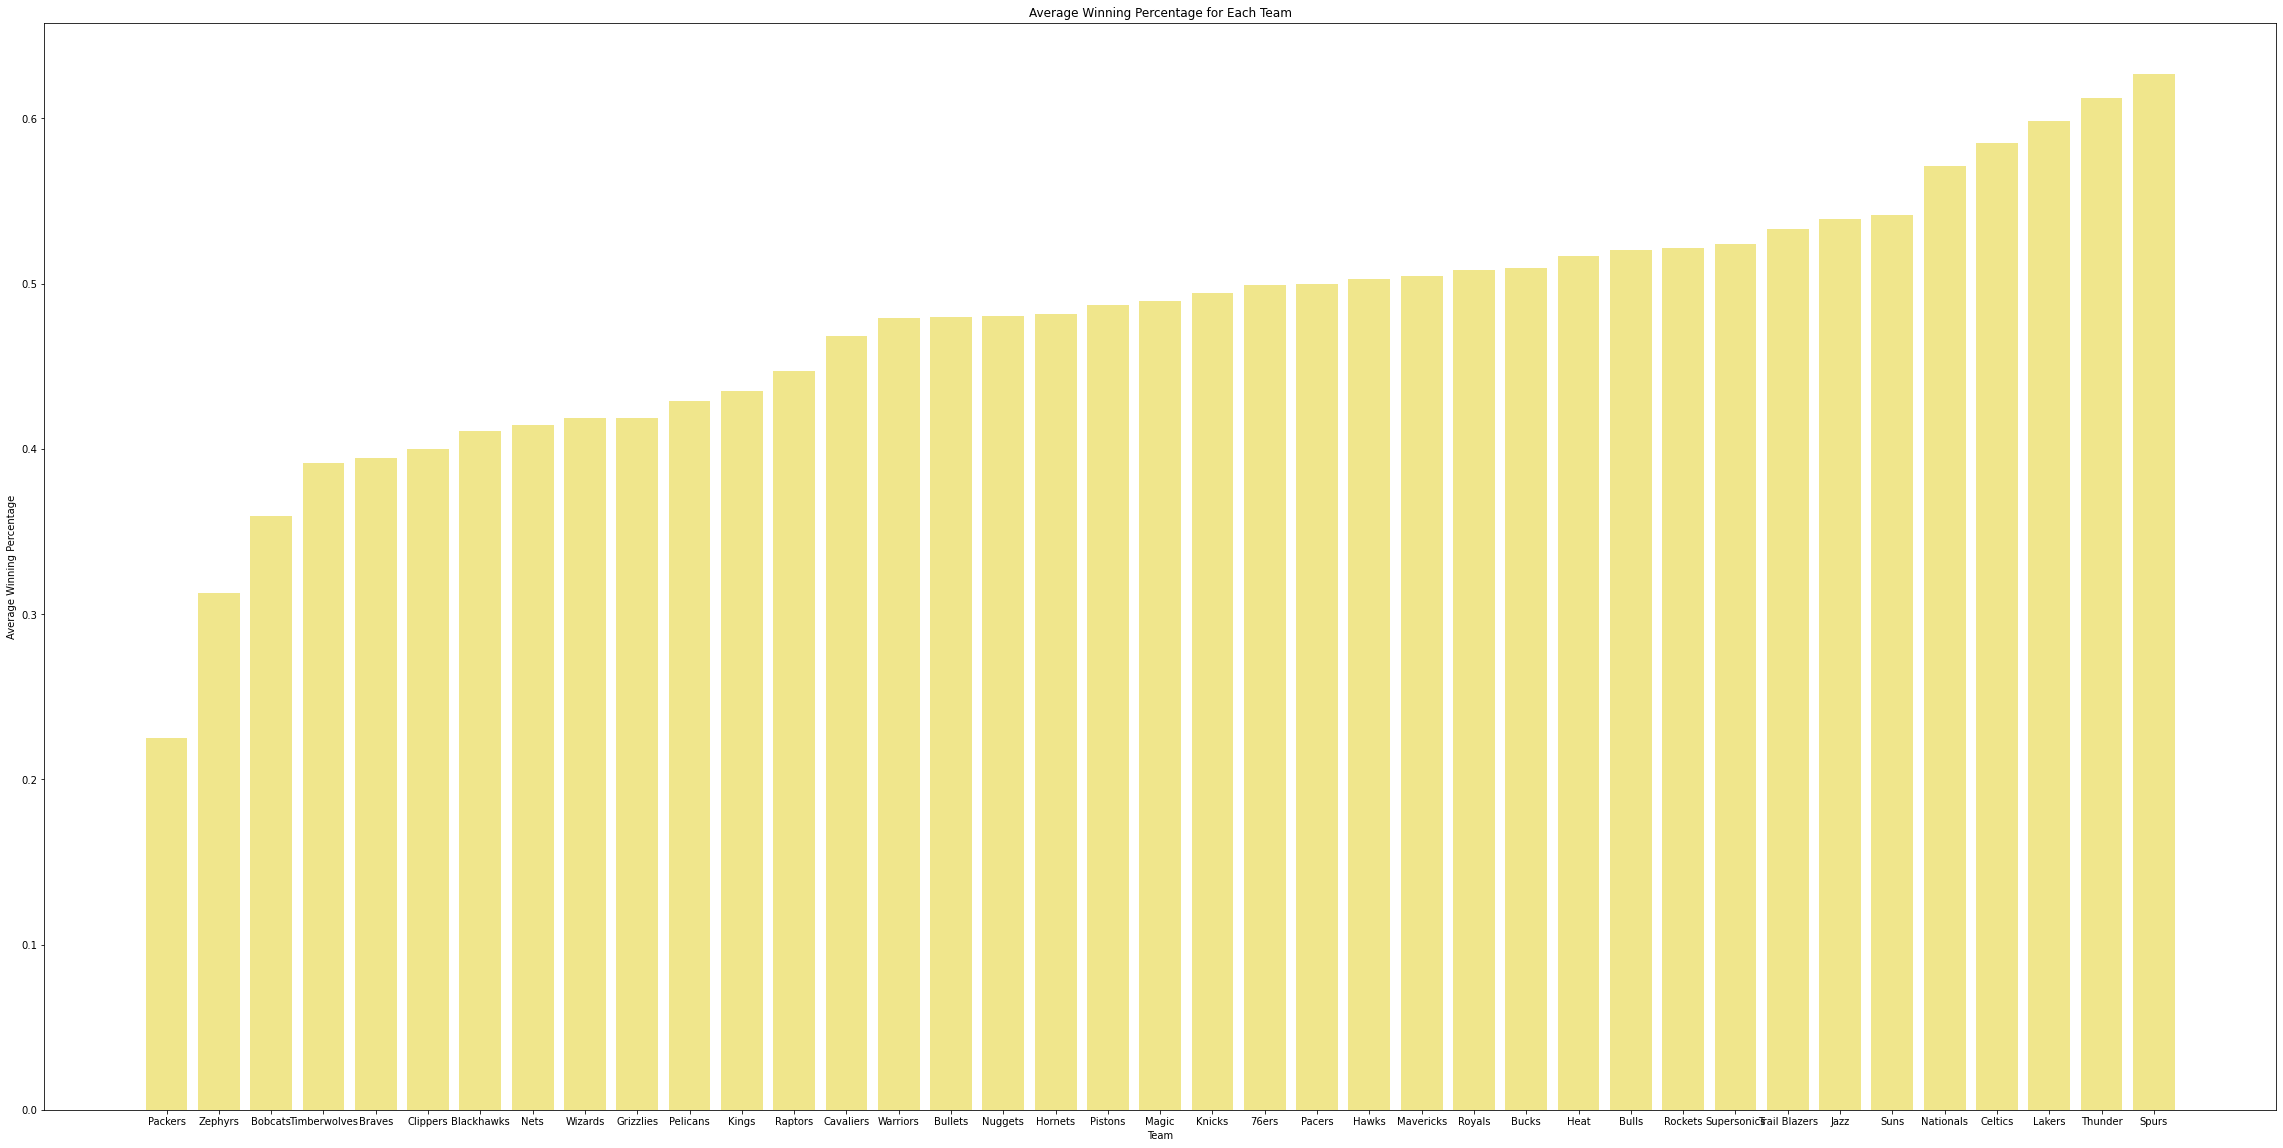

In [69]:
plt.figure(figsize= (40,20))
plt.bar(
    x=historical_percentage["Team"], 
    height=historical_percentage["Average_Winning_Percentage"], 
    color="khaki")
plt.xlabel("Team")
plt.ylabel("Average Winning Percentage")
plt.title("Average Winning Percentage for Each Team")
plt.show()

Spurs have the maximum average winning percentage, which is higher than 0.6. Pickers have the minimum average winning percentage, which is around 0.23.

## 9. Data Analysis for Attendance

In [70]:
query = 'SELECT * from Attendance'
cursor.execute(query)
cols = [column[0] for column in cursor.description]
attendance = pd.DataFrame.from_records(data = cursor.fetchall(), columns = cols)
attendance.head()

,Starting Year,Rank,Team,Home: Total Games,Home: Total Attendance,Home: Avg Attendance,Home: % Capactiy,Away: Total Games,Away: Total Attendance,Away: Avg Attendance,Away: % Capactiy,Id,FullName
0,2015.0,1.0,Bulls,41.0,894659.0,21820.0,104.3,41.0,18156.0,94.5,82.0,1610612741,Chicago Bulls
1,2015.0,2.0,Cavaliers,41.0,843042.0,20562.0,100.0,41.0,18910.0,98.2,82.0,1610612739,Cleveland Cavaliers
2,2015.0,3.0,Mavericks,41.0,825901.0,20143.0,104.9,41.0,17727.0,93.4,82.0,1610612742,Dallas Mavericks
3,2015.0,4.0,Raptors,41.0,812863.0,19825.0,100.1,41.0,17162.0,89.2,82.0,1610612761,Toronto Raptors
4,2015.0,5.0,NY Knicks,41.0,812292.0,19812.0,100.0,41.0,18440.0,96.0,82.0,1610612752,New York Knicks


In [71]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Starting Year           476 non-null    float64
 1   Rank                    476 non-null    float64
 2   Team                    476 non-null    object 
 3   Home: Total Games       476 non-null    float64
 4   Home: Total Attendance  476 non-null    float64
 5   Home: Avg Attendance    476 non-null    float64
 6   Home: % Capactiy        476 non-null    object 
 7   Away: Total Games       476 non-null    float64
 8   Away: Total Attendance  476 non-null    float64
 9   Away: Avg Attendance    476 non-null    object 
 10  Away: % Capactiy        476 non-null    float64
 11  Id                      476 non-null    object 
 12  FullName                476 non-null    object 
dtypes: float64(8), object(5)
memory usage: 48.5+ KB


This table shows the attendance data for each team and their ranks.